In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, GlobalMaxPooling2D, BatchNormalization, Activation, Dropout, Flatten
from tensorflow.keras.utils import to_categorical
import tensorboard
import numpy as np
import logging
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
for device in physical_devices:
    try:
        tf.config.experimental.set_memory_growth(device, True)
    except:
        pass

logging.getLogger().setLevel(logging.INFO)

In [3]:
def get_cifar100():
    def create_superclass(x):
        fine_id_coarse_id ={0: 4,1: 1,2: 14,3: 8,4: 0,5: 6,6: 7,7: 7,8: 18,9: 3,10: 3,11: 14,12: 9,13: 18,14: 7,15: 11,16: 3,17: 9,18: 7,19: 11,20: 6,21: 11,22: 5,23: 10,24: 7,25: 6,26: 13,27: 15,28: 3,29: 15,30: 0,31: 11,32: 1,33: 10,34: 12,35: 14,36: 16,
                            37: 9,38: 11,39: 5,40: 5,41: 19,42: 8,43: 8,44: 15,45: 13,46: 14,47: 17,48: 18,49: 10,50: 16,51: 4,52: 17,53: 4,54: 2,55: 0,56: 17,57: 4,58: 18,59: 17,60: 10,61: 3,62: 2,63: 12,64: 12,65: 16,66: 12,67: 1,68: 9,69: 19,70: 2,71: 10,72: 0,73: 1,74: 16,
                            75: 12,76: 9,77: 13,78: 15,79: 13,80: 16,81: 19,82: 2,83: 4,84: 6,85: 19,86: 5,87: 5,88: 8,89: 19,90: 18,91: 1,92: 2,93: 15,94: 6,95: 0,96: 17,97: 8,98: 14,99: 13}
        return fine_id_coarse_id[x]
    v_create_superclass = np.vectorize(create_superclass)
    
    def create_ultraclass(x):
        coarse_id_ultra_id ={0: 0, 1: 4, 2: 1, 3: 2, 4: 1, 5: 2, 6: 2, 7: 3 ,8: 4, 9: 6, 10: 6, 11: 4, 12: 0, 13: 3, 14: 0, 15: 4, 16: 0, 17: 6, 18: 5, 19: 5}
        return coarse_id_ultra_id[x]
    v_create_ultraclass = np.vectorize(create_ultraclass)
    
    (x_train, y_sub_train), (x_test, y_sub_test) = keras.datasets.cifar100.load_data(label_mode='fine')
    x_train, x_test = x_train / 255, x_test / 255
    y_super_train, y_super_test = v_create_superclass(y_sub_train), v_create_superclass(y_sub_test)
    y_ultra_train, y_ultra_test = v_create_ultraclass(y_super_train), v_create_ultraclass(y_super_test)
    
    return (x_train, to_categorical(y_ultra_train), to_categorical(y_super_train), to_categorical(y_sub_train)), (x_test, to_categorical(y_ultra_test), to_categorical(y_super_test), to_categorical(y_sub_test))

In [4]:
def get_labels(idx, level = 'super'):
    labels = {
        'ultra': ['mammal', 'plant', 'household', 'invertebrates', 'other animal', 'vehicles', 'nature'],
        
        'super':['aquatic mammals', 'fish', 'flowers', 'food containers', 'fruit & vegetables', 
                 'household electrical device', 'household furniture', 'insects', 'large carnivores',
                 'large man-made outdoor things', 'large natural outdoor scenes', 'large omnivores and herbivores',
                 'medium-sized mammals', 'non-insect invertebrates', 'people', 'reptiles', 'small mammals', 'trees', 'vehicles 1', 'vehicles 2'
                ],
        'sub': [
                'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 
                'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 
                'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 
                'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 
                'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 
                'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion',
                'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse',
                'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear',
                'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine',
                'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose',
                'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake',
                'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table',
                'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout',
                'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman',
                'worm'
            ]
    }
    return labels[level][idx]

v_get_labels = np.vectorize(get_labels)

In [5]:
def plot_sample_images(inputs, v_label_func, top_n = 14, n_col = 7):
    (images, ultra_labels_idx, super_labels_idx, sub_labels_idx) = inputs
    assert len(images) == len(ultra_labels_idx) == len(super_labels_idx) == len(sub_labels_idx)
    ultra_labels, super_labels, sub_labels = v_label_func(np.argmax(ultra_labels_idx, axis = 1), 'ultra'), v_label_func(np.argmax(super_labels_idx, axis = 1), 'super'),  v_label_func(np.argmax(sub_labels_idx, axis = 1), 'sub')
    top_n = top_n if top_n < len(images) else len(images)
    n_row = int(top_n/n_col)
    images = images[:top_n]
    figsize = (4 * n_col, 3.5 * n_row)
    fig, axes = plt.subplots(n_row, n_col, figsize = figsize)
    for idx, image in enumerate(images):
        ax = axes[idx // n_col, idx % n_col]
        ax.imshow(image)
        ax.set_title(f"{ultra_labels[idx]} - {super_labels[idx]} - {sub_labels[idx]}")
    plt.tight_layout()
    plt.show()

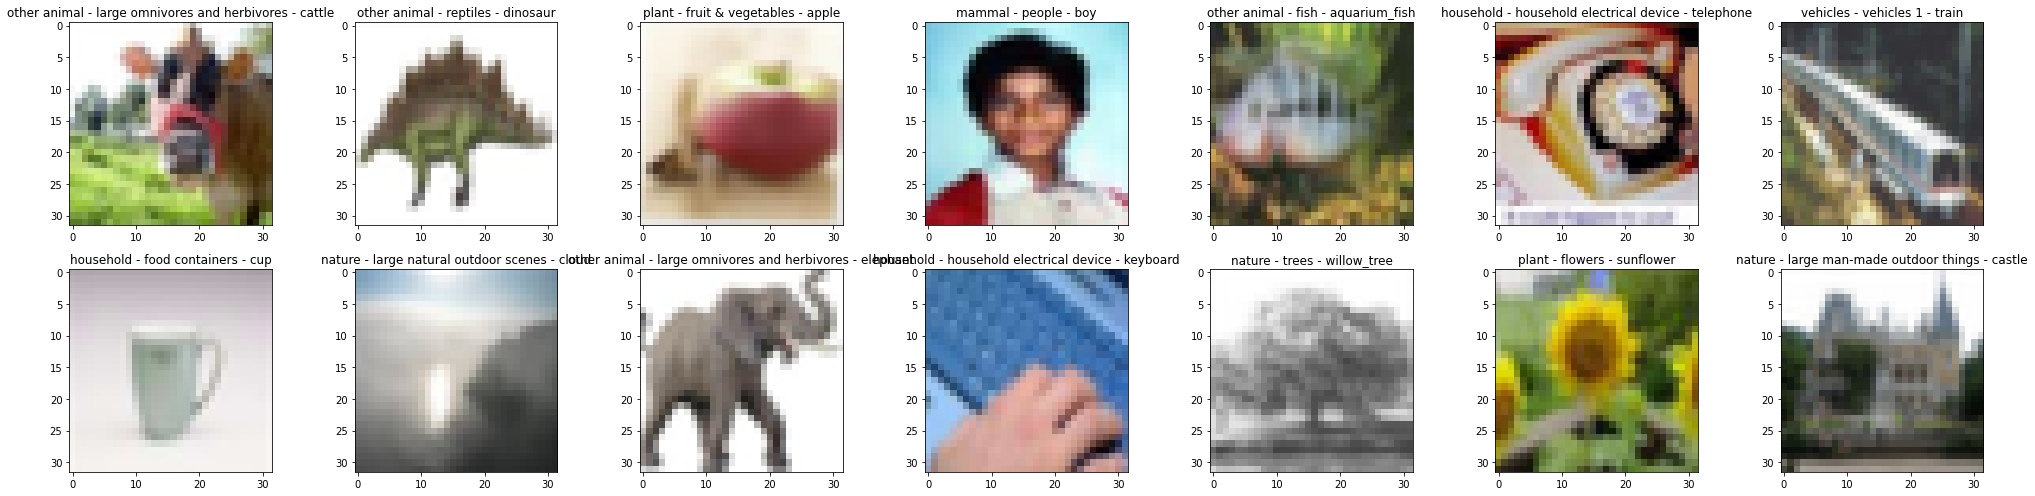

In [6]:
(x_train,y_ultra_train, y_super_train, y_sub_train), (x_test, y_ultra_test, y_super_test, y_sub_test) = get_cifar100()
plot_sample_images((x_train,y_ultra_train, y_super_train, y_sub_train), v_get_labels)

In [7]:
def gen_hierarchy(super_label, sub_label, use_argmax = False):
    combined_labels = np.stack((np.argmax(super_label, axis = 1), np.argmax(sub_label, axis = 1)), axis = 1)
    unique_combinations = np.unique(combined_labels, axis = 0)
    hierarchy={}
    for combination in unique_combinations:
        super_class, sub_class = combination
        if super_class in hierarchy.keys():
            hierarchy[super_class].append(sub_class)
        else:
            hierarchy[super_class] = [sub_class]
    return hierarchy

In [8]:
def conv_block(units, kernel_size = (3,3), stride=(1, 1), dropout=0.3, activation='relu', block=1, layer=1, class_type='default', enable_dropout=True, initializer = tf.keras.initializers.GlorotNormal()):
    def layer_wrapper(inp):
        x = Conv2D(units, kernel_size, padding='same', kernel_initializer = initializer, name=f'{class_type}_block{block}_conv{layer}')(inp)
        x = Activation(activation, name=f'{class_type}_block{block}_act{layer}')(x)
        x = BatchNormalization(name=f'{class_type}_block{block}_bn{layer}')(x)
        if enable_dropout:
            x = Dropout(dropout, name=f'{class_type}_block{block}_dropout{layer}')(x)
        return x
    return layer_wrapper

def dense_block(units, dropout=0.3, activation='relu', name='default_fc1', enable_dropout=True, initializer = tf.keras.initializers.GlorotNormal()):
    def layer_wrapper(inp):
        x = Dense(units, kernel_initializer = initializer, name=name)(inp)
#         x = BatchNormalization(name='{}_bn'.format(name))(x)
        x = Activation(activation, name='{}_act'.format(name))(x)
        if enable_dropout:
            x = Dropout(dropout, name='{}_dropout'.format(name))(x)
        return x
    return layer_wrapper


def create_classifier(img_input, n_classes,conv_dropout=0.3, fc_dropout=0.4, activation='relu', class_type = 'default', nodes = 64):
    
    # Block 1
    block = 1
    x = conv_block(nodes, dropout=conv_dropout, activation=activation, block=block, layer=1, class_type=class_type)(img_input)
    x = conv_block(nodes, dropout=conv_dropout, activation=activation, block=block, layer=2, class_type=class_type, enable_dropout=False)(x)
    x = MaxPooling2D((2, 2), name=f'{class_type}_block{block}_pool')(x)
    
    # Block 2
    block += 1
    x = conv_block(nodes * 2, dropout=conv_dropout, activation=activation, block=block, layer=1, class_type=class_type)(x)
    x = conv_block(nodes * 2, dropout=conv_dropout, activation=activation, block=block, layer=2, class_type=class_type, enable_dropout=False)(x)
    x = MaxPooling2D((2, 2), name=f'{class_type}_block{block}_pool')(x)

    # Block 3
    block += 1
    x = conv_block(nodes * 4, dropout=conv_dropout, activation=activation, block=block, layer=1, class_type=class_type)(x)
    x = conv_block(nodes * 4, dropout=conv_dropout, activation=activation, block=block, layer=2, class_type=class_type, enable_dropout=False)(x)
    x = MaxPooling2D((2, 2), name=f'{class_type}_block{block}_pool')(x)

    # Block 4
    block += 1
    x = conv_block(nodes * 8, dropout=conv_dropout, activation=activation, block=block, layer=1, class_type=class_type)(x)
    x = conv_block(nodes * 8, dropout=conv_dropout, activation=activation, block=block, layer=2, class_type=class_type, enable_dropout=False)(x)
    x = MaxPooling2D((2, 2), name=f'{class_type}_block{block}_pool')(x)

#     x = GlobalAveragePooling2D(f'{class_type}_gap')(x)
    x = Flatten(name=f'{class_type}_flatten')(x)
    
    # FC Layers
    x = dense_block(nodes * 8, dropout=fc_dropout, activation=activation, name=f'{class_type}_fc1')(x)
#     x = dense_block(nodes * 8, dropout=fc_dropout, activation=activation, name=f'{class_type}_fc2', enable_dropout=False)(x)
    
    # Classification block    
    x = Dense(n_classes, activation='softmax', name=f'{class_type}_output')(x)
    
    return x

In [9]:
n_ultraclasses = 7
n_superclasses = 20
n_subclasses = 100
input_shape = x_train[0].shape

img_input = Input(shape=input_shape, name='input')

ultra_class_branch = create_classifier(img_input, n_ultraclasses ,class_type = 'ultra')
super_class_branch = create_classifier(img_input, n_superclasses ,class_type = 'super')
sub_class_branch = create_classifier(img_input, n_subclasses ,class_type = 'sub')
model = keras.Model(inputs=img_input,
             outputs = [ultra_class_branch, super_class_branch, sub_class_branch],
             name="cifar100")

In [10]:
init_lr = 1e-3
lr_decay = 1e-6
epochs = 120
opt = keras.optimizers.Adam(lr=init_lr, decay=lr_decay)

model.compile(
    optimizer=opt,
    loss={
        'ultra_output':'categorical_crossentropy',
        'super_output':'categorical_crossentropy',
        'sub_output':'categorical_crossentropy'
    },
    metrics={
        'ultra_output':'accuracy',
        'super_output':'accuracy',
        'sub_output':'accuracy'
    }
)

In [11]:
model.summary()

Model: "cifar100"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
ultra_block1_conv1 (Conv2D)     (None, 32, 32, 64)   1792        input[0][0]                      
__________________________________________________________________________________________________
super_block1_conv1 (Conv2D)     (None, 32, 32, 64)   1792        input[0][0]                      
__________________________________________________________________________________________________
sub_block1_conv1 (Conv2D)       (None, 32, 32, 64)   1792        input[0][0]                      
___________________________________________________________________________________________

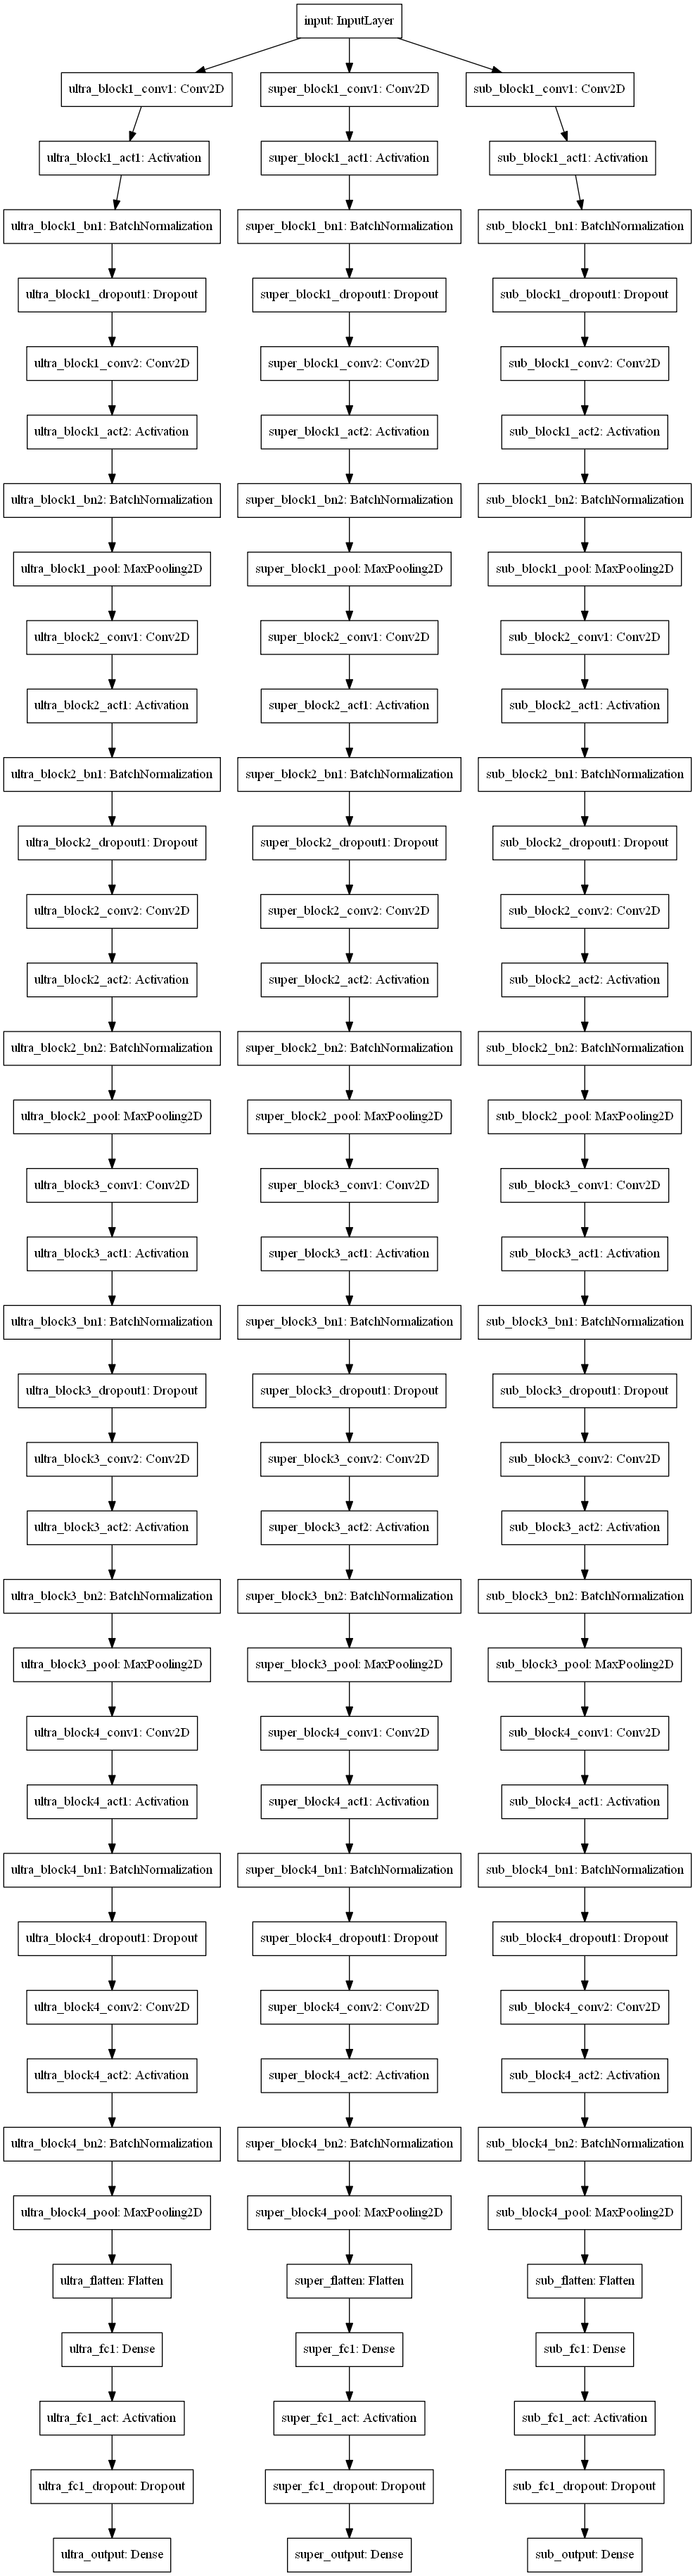

In [12]:
tf.keras.utils.plot_model(model, show_shapes=False, show_dtype=False, show_layer_names=True, rankdir='TB', expand_nested=False)

In [13]:
logdir = "./logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")

# tensorboard_callback = keras.callbacks.TensorBoard(
#     log_dir=logdir,
#     histogram_freq=1
# )

# earlystop_callback = keras.callbacks.EarlyStopping(
#     monitor='val_loss', 
#     min_delta=1e-5,
#     mode = 'min',
#     patience=50,
#     verbose=1
# )

# def lr_scheduler(epoch):
#     return learning_rate * (0.5 ** (epoch // lr_drop))

# reduce_lr = keras.callbacks.LearningRateScheduler(lr_scheduler)

# checkpoint_callbacks = [
#     keras.callbacks.ModelCheckpoint("./model_checkpoint", monitor='val_loss')
# ]

history = model.fit(
    x_train, 
    y={"ultra_output": y_ultra_train, "super_output": y_super_train, "sub_output": y_sub_train},
    validation_data=(x_test,{"ultra_output": y_ultra_test, "super_output": y_super_test, "sub_output": y_sub_test}),
    batch_size = 128,
    epochs=epochs,
    validation_split=0.2,
    use_multiprocessing=True,
#     callbacks=[
# #         tensorboard_callback,
#         earlystop_callback,
# #         reduce_lr
#     ]
)

Epoch 1/120
313/313 [==============================] - 36s 88ms/step - loss: 9.9585 - ultra_output_loss: 2.2571 - super_output_loss: 3.1115 - sub_output_loss: 4.5899 - ultra_output_accuracy: 0.3379 - super_output_accuracy: 0.1627 - sub_output_accuracy: 0.0376 - val_loss: 12.4138 - val_ultra_output_loss: 2.2885 - val_super_output_loss: 4.5829 - val_sub_output_loss: 5.5424 - val_ultra_output_accuracy: 0.2007 - val_super_output_accuracy: 0.0588 - val_sub_output_accuracy: 0.0117
Epoch 2/120
313/313 [==============================] - 25s 80ms/step - loss: 7.4875 - ultra_output_loss: 1.3725 - super_output_loss: 2.2940 - sub_output_loss: 3.8210 - ultra_output_accuracy: 0.4761 - super_output_accuracy: 0.2950 - sub_output_accuracy: 0.1089 - val_loss: 7.7495 - val_ultra_output_loss: 1.4388 - val_super_output_loss: 2.3670 - val_sub_output_loss: 3.9437 - val_ultra_output_accuracy: 0.4765 - val_super_output_accuracy: 0.2988 - val_sub_output_accuracy: 0.1220
Epoch 3/120
313/313 [====================

In [14]:
yhat_ultra_test, yhat_super_test, yhat_sub_test = model.predict(x_test, use_multiprocessing=True)

In [15]:
y_ultra, yhat_ultra = v_get_labels(np.argmax(y_ultra_test, axis=1), 'ultra'), v_get_labels(np.argmax(yhat_ultra_test, axis=1), 'ultra')
y_super, yhat_super = v_get_labels(np.argmax(y_super_test, axis=1), 'super'), v_get_labels(np.argmax(yhat_super_test, axis=1), 'super')
y_sub, yhat_sub = v_get_labels(np.argmax(y_sub_test, axis=1),'sub'), v_get_labels(np.argmax(yhat_sub_test, axis=1),'sub')

In [16]:
pd.crosstab(y_ultra, yhat_ultra, rownames=['Actual'], colnames=['Pred'])

Pred,household,invertebrates,mammal,nature,other animal,plant,vehicles
Actual,,,,,,,
household,1275,40,70,48,31,16,20
invertebrates,57,656,132,23,88,35,9
mammal,85,59,1611,30,192,12,11
nature,35,19,31,1362,31,4,18
other animal,86,119,533,75,1139,26,22
plant,56,40,42,20,39,801,2
vehicles,72,23,42,73,29,1,760


In [17]:
pd.crosstab(y_super, yhat_super, rownames=['Actual'], colnames=['Pred'])

Pred,aquatic mammals,fish,flowers,food containers,fruit & vegetables,household electrical device,household furniture,insects,large carnivores,large man-made outdoor things,large natural outdoor scenes,large omnivores and herbivores,medium-sized mammals,non-insect invertebrates,people,reptiles,small mammals,trees,vehicles 1,vehicles 2
Actual,,,,,,,,,,,,,,,,,,,,
aquatic mammals,276,25,0,3,4,10,1,1,14,8,8,10,26,11,7,49,39,2,2,4
fish,35,292,4,11,11,5,6,6,5,4,5,9,10,11,10,52,14,4,1,5
flowers,1,4,377,10,46,1,1,18,5,1,2,1,3,9,5,5,5,5,0,1
food containers,2,3,3,387,17,37,11,3,1,5,0,3,5,6,5,2,4,0,2,4
fruit & vegetables,2,2,30,9,381,3,1,10,12,1,3,6,3,9,5,12,10,1,0,0
household electrical device,2,6,5,48,5,344,29,3,5,7,7,2,2,8,4,10,2,2,3,6
household furniture,0,3,2,26,5,26,377,2,3,12,7,0,0,7,3,6,10,0,4,7
insects,6,10,17,7,13,3,2,311,12,3,0,3,12,36,5,35,11,5,1,8
large carnivores,25,4,0,5,1,5,6,8,278,3,7,39,36,2,7,32,35,4,2,1


In [18]:
pd.crosstab(y_sub, yhat_sub, rownames=['Actual'], colnames=['Pred'])

Pred,apple,aquarium_fish,baby,bear,beaver,bed,bee,beetle,bicycle,bottle,...,train,trout,tulip,turtle,wardrobe,whale,willow_tree,wolf,woman,worm
Actual,,,,,,,,,,,,,,,,,,,,,
apple,77,0,0,0,0,0,0,0,0,0,...,0,0,4,0,0,0,0,0,0,0
aquarium_fish,3,55,0,0,0,0,0,0,0,0,...,1,3,3,2,0,1,0,0,0,1
baby,3,1,28,0,0,2,1,0,1,1,...,0,0,0,0,0,0,0,1,7,0
bear,0,0,0,33,4,0,1,0,0,0,...,0,0,0,0,0,1,0,1,0,0
beaver,0,0,1,1,30,0,0,0,0,0,...,0,1,0,1,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
whale,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,67,0,0,0,1
willow_tree,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,42,0,0,0
wolf,1,1,0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,56,1,0


In [19]:
def calculate_hiearchy_mismatch(super_labels, sub_labels, hierarchy):
    mismatch = 0
    assert len(super_labels) == len(sub_labels)
    for idx, super_label in enumerate(super_labels):
        if sub_labels[idx] not in hierarchy[super_label]:
            mismatch += 1
    return mismatch

In [20]:
n_rows = len(x_test)
error_rate_ultra = sum(y_ultra != yhat_ultra) / n_rows
error_rate_super = sum(y_super != yhat_super) / n_rows
error_rate_sub = sum(y_sub != yhat_sub) / n_rows

mismatch_rate = 0

hierarchy = gen_hierarchy(y_ultra_train, y_sub_train)
n_mismatch = calculate_hiearchy_mismatch(np.argmax(yhat_ultra_test, axis=1), np.argmax(yhat_sub_test, axis=1), hierarchy)
mismatch_rate += n_mismatch / n_rows

hierarchy = gen_hierarchy(y_ultra_train, y_super_train)
n_mismatch = calculate_hiearchy_mismatch(np.argmax(yhat_ultra_test, axis=1), np.argmax(yhat_super_test, axis=1), hierarchy)
mismatch_rate += n_mismatch / n_rows

hierarchy = gen_hierarchy(y_super_train, y_sub_train)
n_mismatch = calculate_hiearchy_mismatch(np.argmax(yhat_super_test, axis=1), np.argmax(yhat_sub_test, axis=1), hierarchy)
mismatch_rate += n_mismatch / n_rows

mismatch_rate /= 3

print(f"Ultra Class Error Rate: {error_rate_ultra}\nSuper Class Error Rate: {error_rate_super}\nSub Class Error Rate: {error_rate_sub}\nAverage Mismatch Rate: {mismatch_rate}")

Ultra Class Error Rate: 0.2396
Super Class Error Rate: 0.3247
Sub Class Error Rate: 0.4547
Average Mismatch Rate: 0.2828333333333333
